###  Trotterized Ising model for open line in 1D 
 Following from the Schrödinger equation, the time evolution of a system initially in the state $\vert\psi(0)\rangle$ takes the form:

$$
\vert \psi(t) \rangle = e^{-i H t} \vert \psi(0) \rangle \text{,}
$$

where $H$ is the time-independent Hamiltonian under which the system is submitted. We consider a Hamiltonian that can be written as a weighted sum of Pauli terms $H=\sum_j a_j H_j$, with $H_j$ representing a tensor product of Pauli terms acting on $n$ qubits. Thus, the sequence of gates that approximate a single evolution step is found under the assumption that the product of matrix exponentials is a good approximation for the sum of matrix exponentials:

$$
\vert \psi(t) \rangle \approx \left(\prod_j e^{-i a_j H_j t/r} \right)^r \vert\psi(0) \rangle \text{,}
$$

where $t/r$ is the time slice (evolution step) that we are choosing. As a result, a gate to be applied $r$ times is created. A smaller timestep leads to a more accurate approximation. However, this also leads to deeper circuits which, in practice, leads to more error accumulation, becoming a critical aspect especially on NISQ devices. For the purposes of this tutorial, all simulations are Statevector simulator, which doesn't include any shot or hardware noise.

We will follow paper by Jamadagni at al.: [arXiv:2401.13625v1](https://arxiv.org/html/2401.13625v1).
The Transverse Field Ising Model (TFIM) Hamiltonian for 1D  open chain of length N (without periodic boundary condition) is
$$
H_{TFIM} = -  \sum_{i=0}^{N-2} \sigma_z^i \sigma_z^{i+1} - g(t) \sum_{j=0}^{N-1} \sigma_x^i  \text{,}
$$
where $ g(t)= -t/\tau_Q $ and $\tau_Q$ being the rate of the rate of the quanch. Since $g(t)$ is time-dependent, we'll treat it as a constant for each small time step.

In [2]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.synthesis import SuzukiTrotter
from qiskit.circuit.library import PauliEvolutionGate
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.options.sampler_options import SamplerOptions
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from time import time
import numpy as np

### From Aziz
In fact when you pass your hamiltonian as is a list of several SparsePauliop in the PauliEvolutionGate, you are assuming that each SparsePauliop commute between them but the pauli terms in each SparsePauliop do not commute. For instance, let's consider the SparsePauliOp A=A1+A2, B=B1+B2 where A1,A2,B1,B2 are pauli strings:

1. Passing them in a list like `trotter=PauliEvolutionGate([A,B], dt, synthesis=order_formula)` means that A commute with B but A1 do not commute with A2 and same for B1 and B2. So your circuit is broken in these three steps B/2|A|B/2=(B1+B2)/2(A1+A2)(B1+B2)/2

1. If you do not pass a list, `trotter=PauliEvolutionGate(A+B, dt, synthesis
=order_formula)`, you are considering that all terms A1,A2,B1,B2 commute and the decomposition would be: (A2+B1+B2)/2(A1)(B2+B1+A2)/2

1. If you do `trotter=PauliEvolutionGate([A+B], dt, synthesis=order_formula)`, all terms are not commuting then it will be A1A2B1B2 and it is equivalent to the Lie product.

Depending on how you are passing the list, the result may differ, since you want to decompose each of your 5 hamiltonians in 3 blocks using the suziki trotter approximation, I recommend you to create several PauliEvolutionGate for each of your hamiltonian. Please find in the attachments your notebook modified that shows you how to do that.
 

In [3]:
N = 4  # Number of qubits
J = 1.0  # Interaction strength
tau_Q = 2.0  # Quench time
final_time = 7.0  # Total evolution time
num_timesteps = 5  # Number of time steps
dt = final_time / num_timesteps  # Time step size

# Initialize list for Hamiltonians at each time step
HL = []

for step in range(num_timesteps):
    t = step * dt +dt
    g_t = t / tau_Q
    print(len(HL),step,t,g_t)
    pauli_strings = []
    coefficients = []

    # Interaction terms for chain without periodic boundary
    for i in range(N-1):
        z_term = ['I'] * N
        z_term[i] = 'Z'
        z_term[(i + 1) % N] = 'Z'  # Periodic boundary conditions
        pauli_strings.append(''.join(z_term))
        coefficients.append(-J)
    H1 = SparsePauliOp.from_list(zip(pauli_strings, coefficients))

    # Transverse field terms
    pauli_strings = []
    coefficients = []
    for i in range(N):
        x_term = ['I'] * N
        x_term[i] = 'X'
        pauli_strings.append(''.join(x_term))
        coefficients.append(-g_t)
    H2 = SparsePauliOp.from_list(zip(pauli_strings, coefficients))
    # each sub list is a set of the transverse and the interaction term of the hamiltonian
    HL.append([H1,H2])
# HL

0 0 1.4 0.7
1 1 2.8 1.4
2 2 4.199999999999999 2.0999999999999996
3 3 5.6 2.8
4 4 7.0 3.5


In [4]:
print('1st H-step:\n', HL[0])

1st H-step:
 [SparsePauliOp(['ZZII', 'IZZI', 'IIZZ'],
              coeffs=[-1.+0.j, -1.+0.j, -1.+0.j]), SparsePauliOp(['XIII', 'IXII', 'IIXI', 'IIIX'],
              coeffs=[-0.7+0.j, -0.7+0.j, -0.7+0.j, -0.7+0.j])]


The second-order formula, called the Suzuki-Trotter decomposition [3], and can be used in Qiskit by means of the [SuzukiTrotter class](https://docs.quantum.ibm.com/api/qiskit/qiskit.synthesis.SuzukiTrotter). Using this formula, a second order decomposition is:

$$
e^{A+B} \approx e^{B/2}e^{A}e^{B/2}
$$

By means of recursions, higher-order approximations can be found [1].

In [5]:
order_formula =SuzukiTrotter(order=2 ,reps=1,insert_barriers=True)  # reps:Number of repetitions per time step
qc = QuantumCircuit(N)
qc.x(3)
for H_step in HL:
    trotter=PauliEvolutionGate(H_step, dt, synthesis=order_formula)
    qc.append(trotter, range(N))
    qc.barrier()

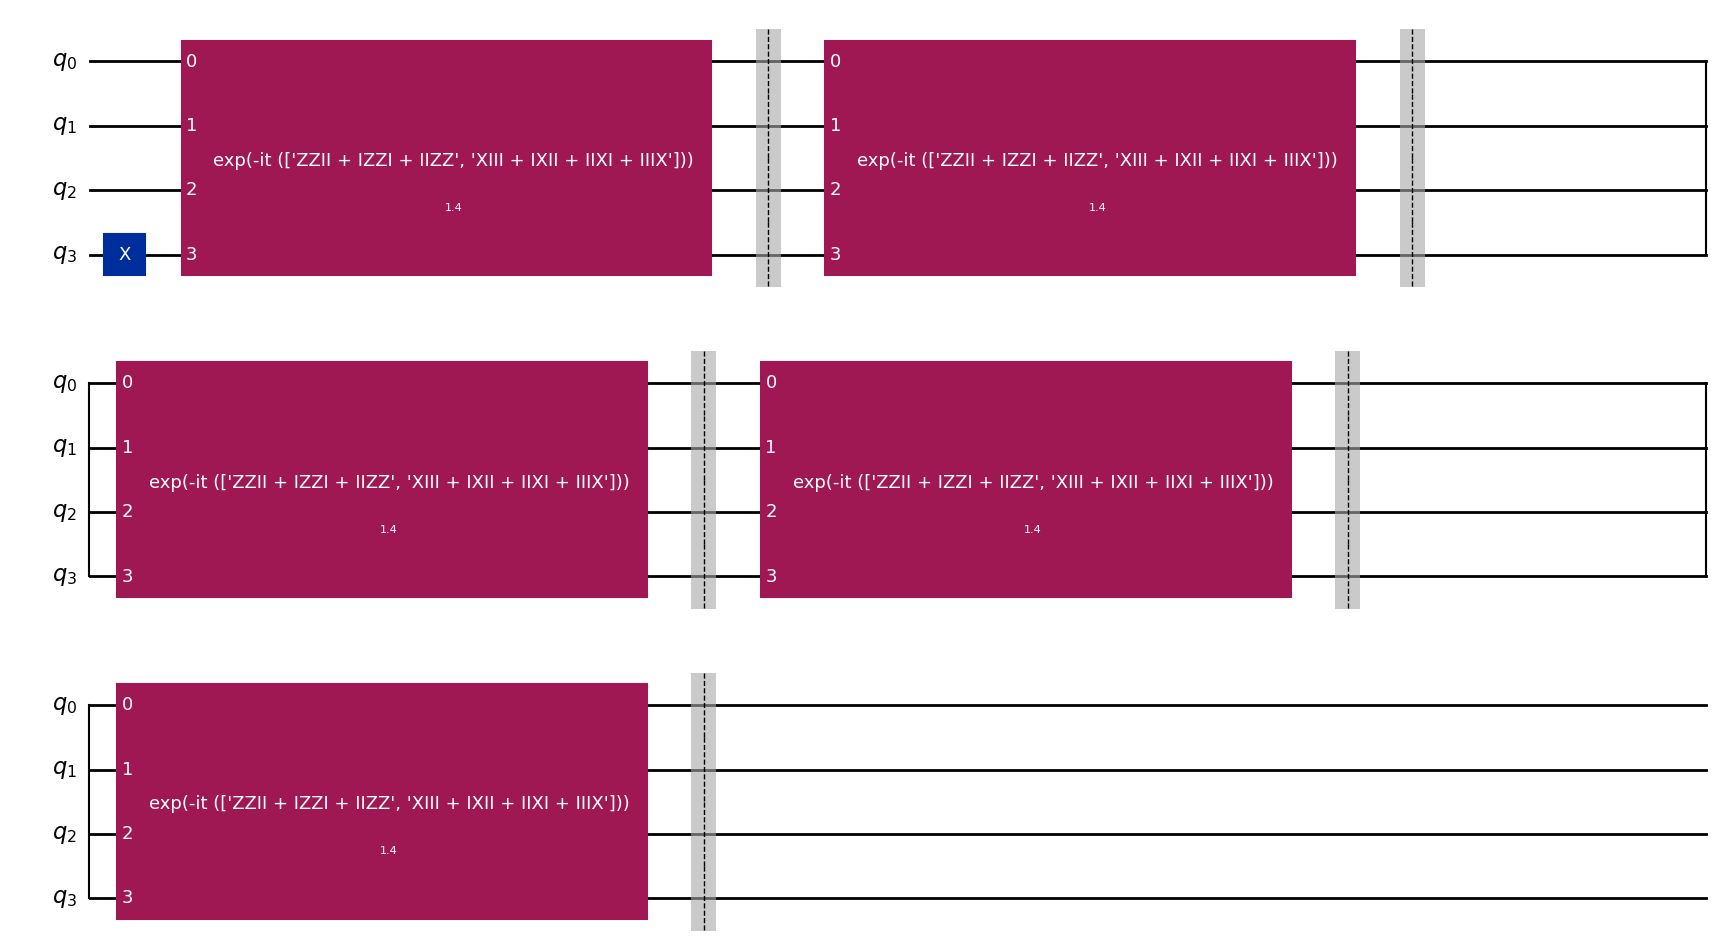

In [6]:
qc.draw('mpl')

job started,  nq=4  at aer_simulator ...
N=4  timesteps=5 depth=36  nonlocal_gates=30
Gate breakdown:RZZ: 30, RX: 20, BARRIER: 15, X: 1


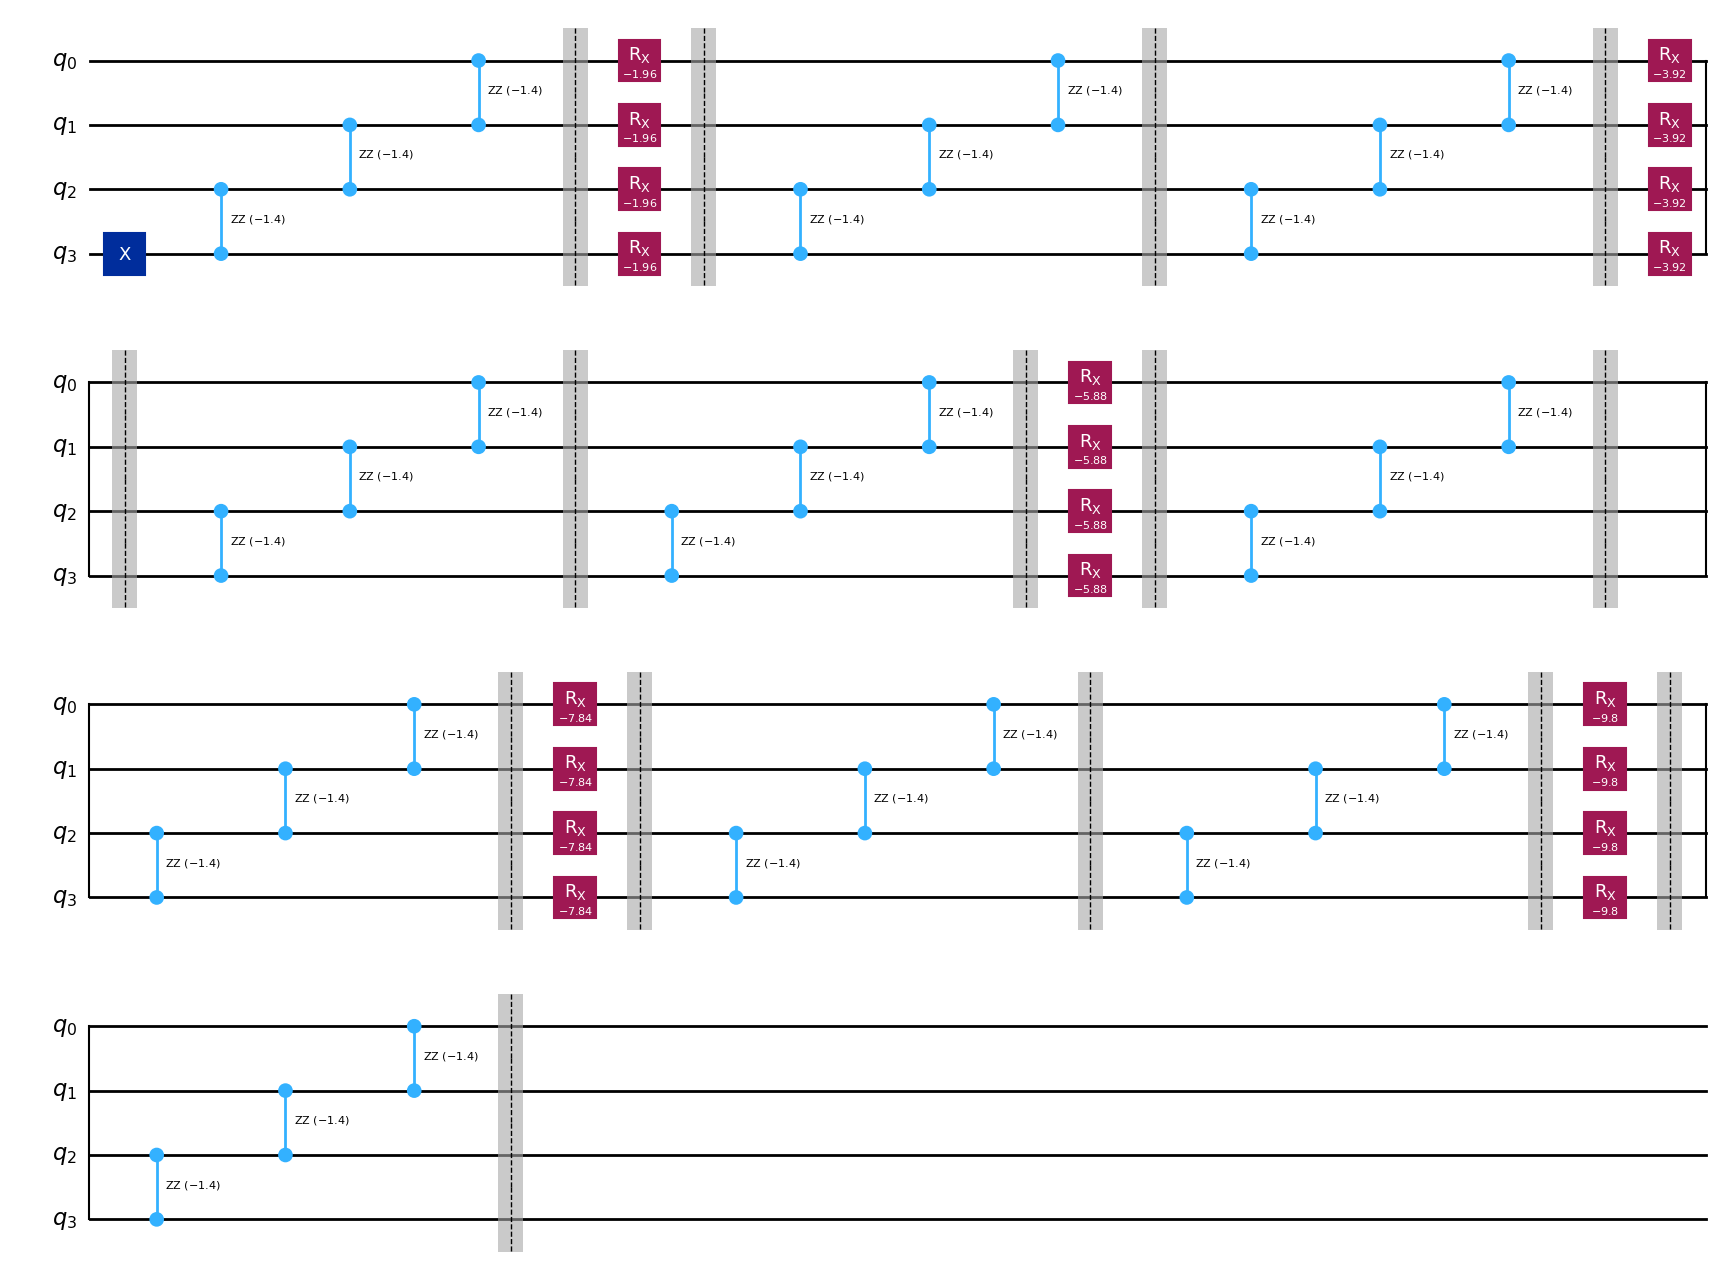

In [7]:
backend = AerSimulator()
print('job started,  nq=%d  at %s ...'%(qc.num_qubits,backend.name))
options = SamplerOptions()
options.default_shots=1000
estimator = Estimator(backend) #, options=options)

pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
qcT = pm.run(qc)
print('N=%d  timesteps=%d depth=%d  nonlocal_gates=%d\nGate breakdown:%s'%(N,num_timesteps,qcT.depth(),qcT.num_nonlocal_gates(),
                                                        ", ".join([f"{k.upper()}: {v}" for k, v in qcT.count_ops().items()])))

qcT.draw("mpl")  # mpl

In [8]:
magnetization_op = SparsePauliOp.from_sparse_list(
    [("Z", [i], 1.0) for i in range(0, N)], num_qubits=N)

observable = magnetization_op.apply_layout(qcT.layout)

In [9]:
job = estimator.run([(qcT, observable)])
result = job.result()
rdata=result[0].data
print("Expectation value: %.3f +/- %.3f "%(rdata.evs,rdata.stds))
print("Metadata: ",result[0].metadata)


Expectation value: -0.141 +/- 0.057 
Metadata:  {'target_precision': 0.015625, 'shots': 4096, 'circuit_metadata': {}}


### Combining all paulis strings in a SparsePauliOp and in a list, so that they do not commute

In [10]:
HL_no_commuting = [sum([sum(HL[i]) for i in range(len(HL))])]
print(HL_no_commuting)

[SparsePauliOp(['ZZII', 'IZZI', 'IIZZ', 'XIII', 'IXII', 'IIXI', 'IIIX', 'ZZII', 'IZZI', 'IIZZ', 'XIII', 'IXII', 'IIXI', 'IIIX', 'ZZII', 'IZZI', 'IIZZ', 'XIII', 'IXII', 'IIXI', 'IIIX', 'ZZII', 'IZZI', 'IIZZ', 'XIII', 'IXII', 'IIXI', 'IIIX', 'ZZII', 'IZZI', 'IIZZ', 'XIII', 'IXII', 'IIXI', 'IIIX'],
              coeffs=[-1. +0.j, -1. +0.j, -1. +0.j, -0.7+0.j, -0.7+0.j, -0.7+0.j, -0.7+0.j,
 -1. +0.j, -1. +0.j, -1. +0.j, -1.4+0.j, -1.4+0.j, -1.4+0.j, -1.4+0.j,
 -1. +0.j, -1. +0.j, -1. +0.j, -2.1+0.j, -2.1+0.j, -2.1+0.j, -2.1+0.j,
 -1. +0.j, -1. +0.j, -1. +0.j, -2.8+0.j, -2.8+0.j, -2.8+0.j, -2.8+0.j,
 -1. +0.j, -1. +0.j, -1. +0.j, -3.5+0.j, -3.5+0.j, -3.5+0.j, -3.5+0.j])]


In [11]:
order_formula =SuzukiTrotter(order=2 ,reps=1,insert_barriers=True)  # reps:Number of repetitions per time step
qc = QuantumCircuit(N)
qc.x(3)
trotter=PauliEvolutionGate(HL_no_commuting, dt, synthesis=order_formula)
qc.append(trotter, range(N))

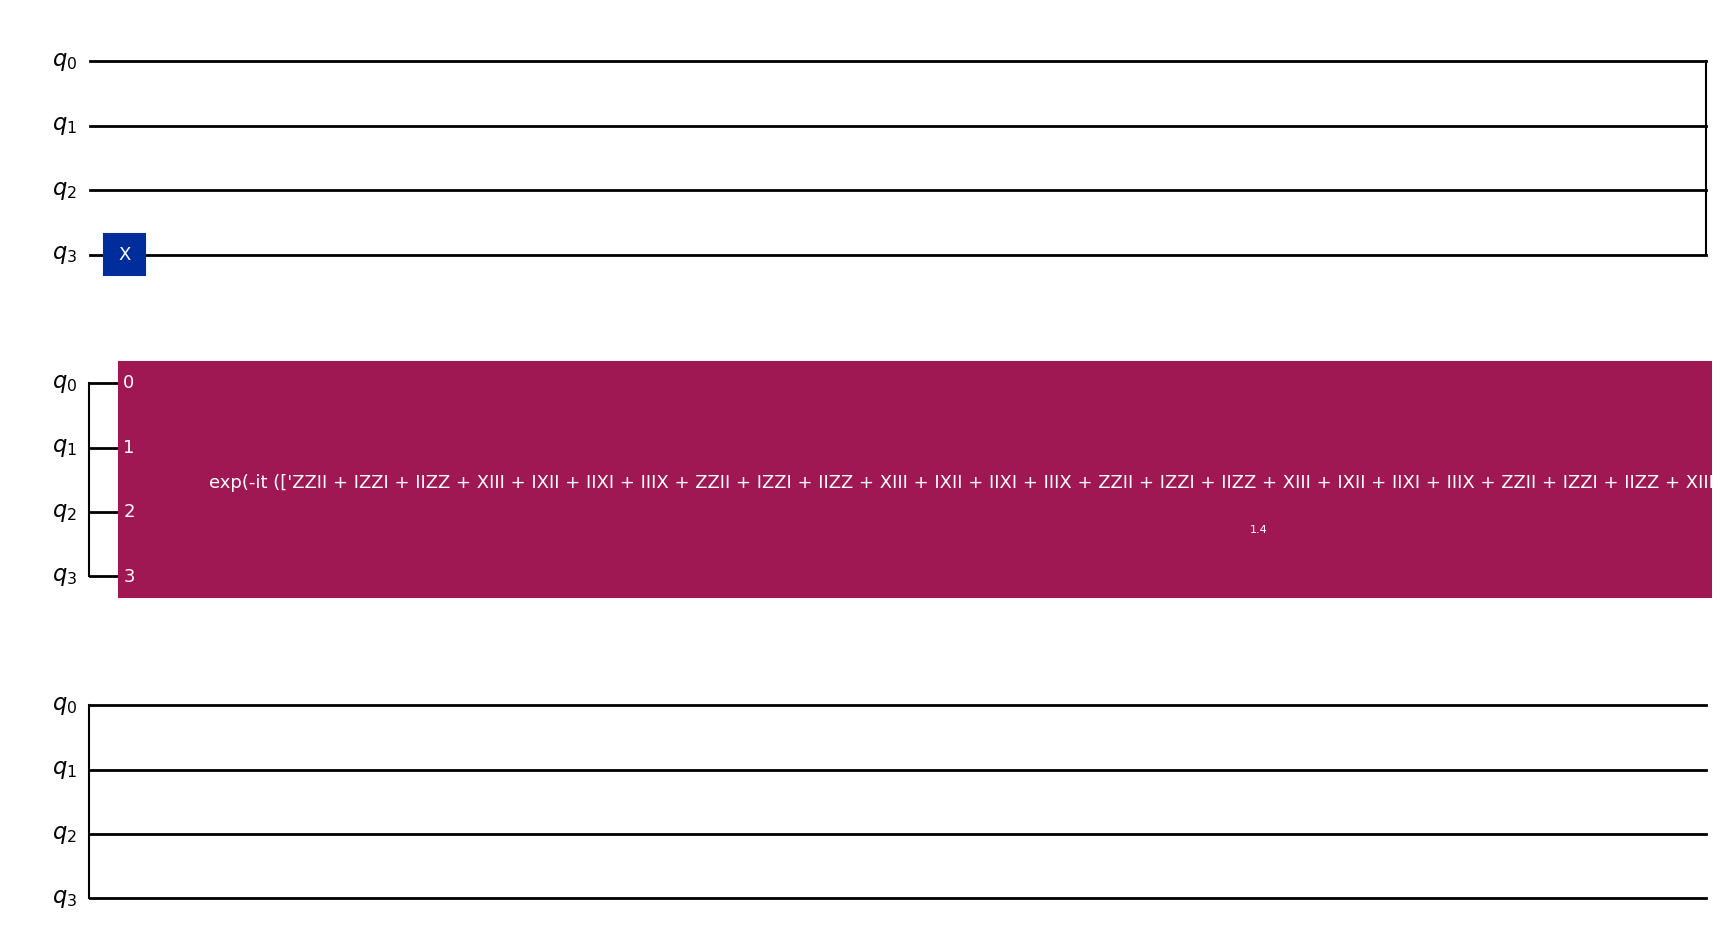

In [12]:
qc.draw('mpl')

job started,  nq=4  at aer_simulator ...
N=4  timesteps=5 depth=17  nonlocal_gates=15
Gate breakdown:RX: 20, RZZ: 15, X: 1


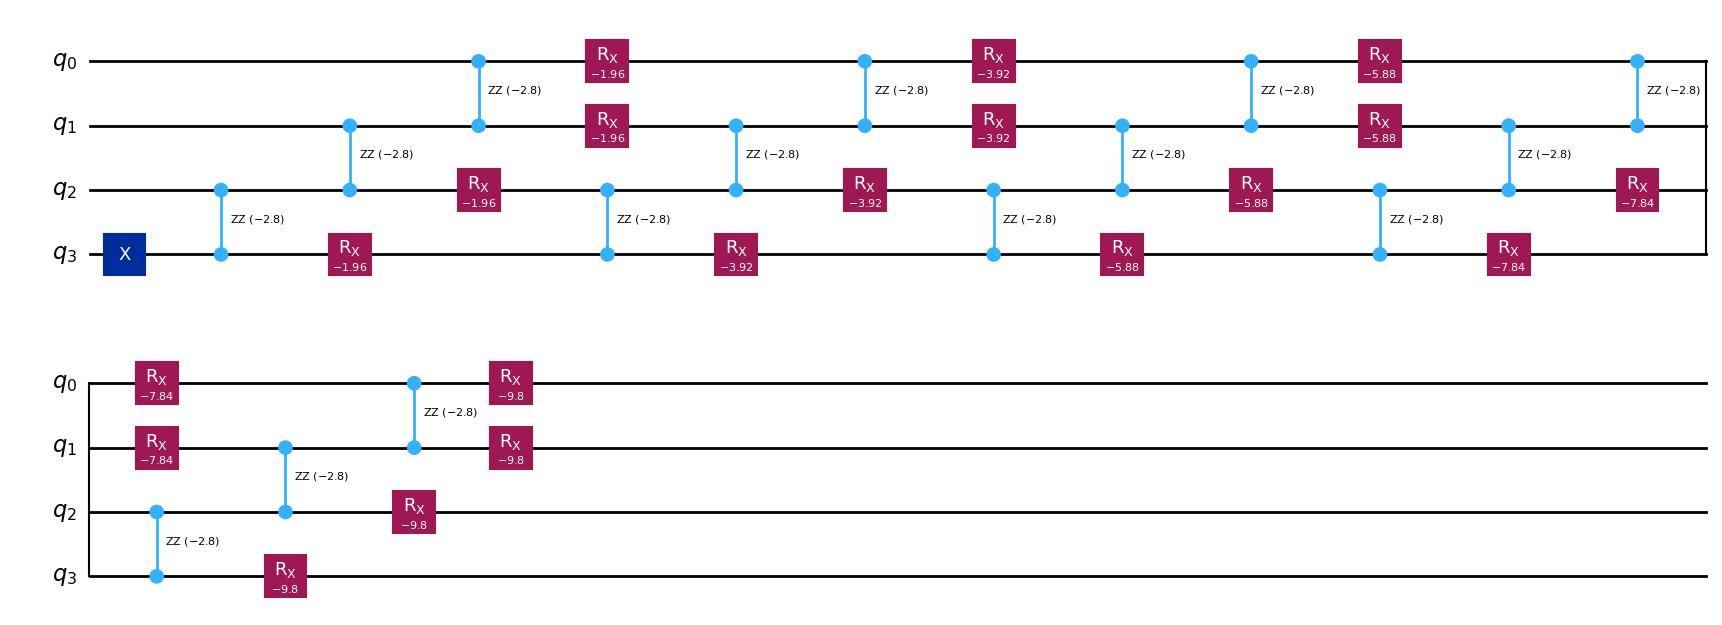

In [13]:
backend = AerSimulator()
print('job started,  nq=%d  at %s ...'%(qc.num_qubits,backend.name))
options = SamplerOptions()
options.default_shots=1000
estimator = Estimator(backend) #, options=options)

pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
qcT = pm.run(qc)
print('N=%d  timesteps=%d depth=%d  nonlocal_gates=%d\nGate breakdown:%s'%(N,num_timesteps,qcT.depth(),qcT.num_nonlocal_gates(),
                                                        ", ".join([f"{k.upper()}: {v}" for k, v in qcT.count_ops().items()])))

qcT.draw("mpl")  # mpl

In [14]:
job = estimator.run([(qcT, observable)])
result = job.result()
rdata=result[0].data
print("Expectation value: %.3f +/- %.3f "%(rdata.evs,rdata.stds))
print("Metadata: ",result[0].metadata)

Expectation value: -0.181 +/- 0.057 
Metadata:  {'target_precision': 0.015625, 'shots': 4096, 'circuit_metadata': {}}


### Using the Lie Trotter

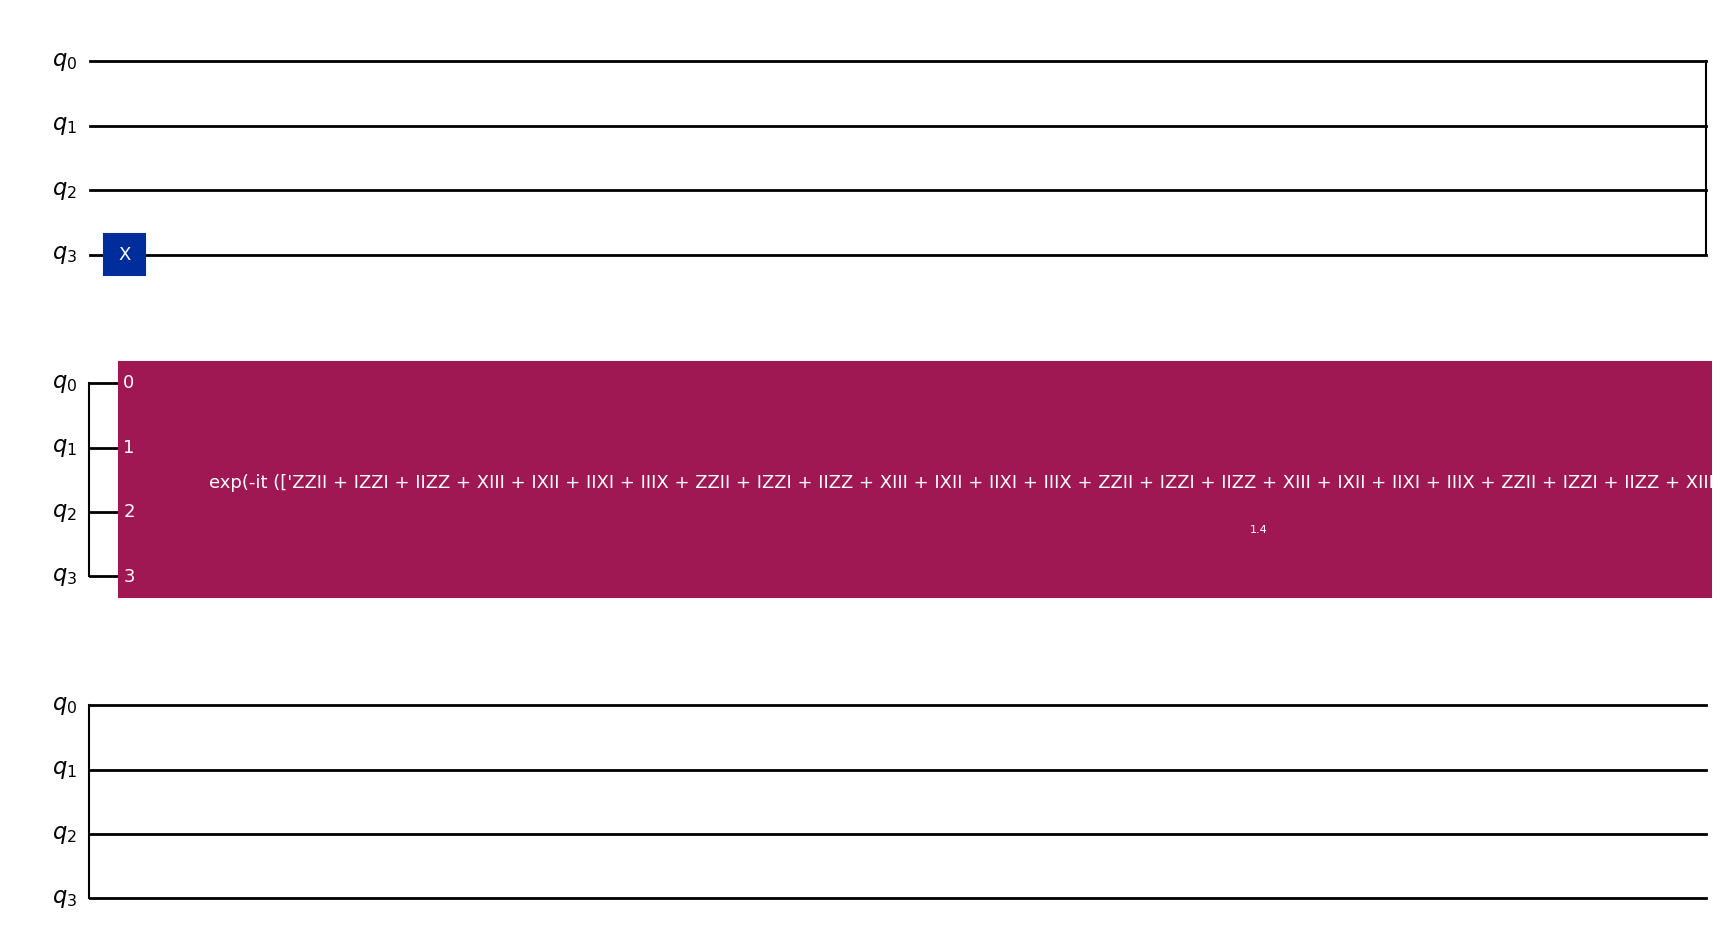

In [15]:
qc = QuantumCircuit(N)
qc.x(3)
trotter=PauliEvolutionGate(HL_no_commuting, dt)# by default the lietrotter is used
qc.append(trotter, range(N))
qc.draw('mpl')

job started,  nq=4  at aer_simulator ...
N=4  timesteps=5 depth=17  nonlocal_gates=15
Gate breakdown:RX: 20, RZZ: 15, X: 1


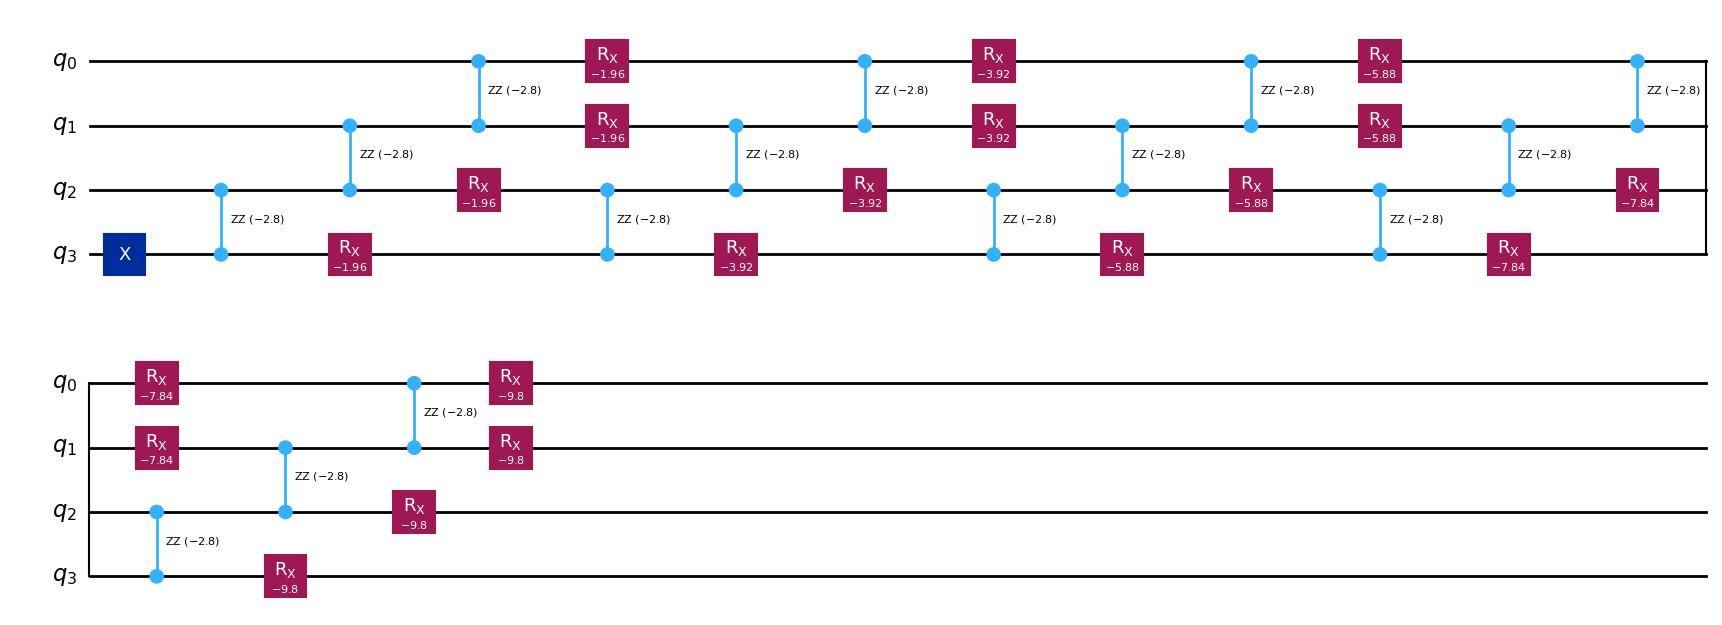

In [16]:
backend = AerSimulator()
print('job started,  nq=%d  at %s ...'%(qc.num_qubits,backend.name))
options = SamplerOptions()
options.default_shots=1000
estimator = Estimator(backend) #, options=options)

pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
qcT = pm.run(qc)
print('N=%d  timesteps=%d depth=%d  nonlocal_gates=%d\nGate breakdown:%s'%(N,num_timesteps,qcT.depth(),qcT.num_nonlocal_gates(),
                                                        ", ".join([f"{k.upper()}: {v}" for k, v in qcT.count_ops().items()])))

qcT.draw("mpl")  # mpl

In [17]:
job = estimator.run([(qcT, observable)])
result = job.result()
rdata=result[0].data
print("Expectation value: %.3f +/- %.3f "%(rdata.evs,rdata.stds))
print("Metadata: ",result[0].metadata)

Expectation value: -0.193 +/- 0.057 
Metadata:  {'target_precision': 0.015625, 'shots': 4096, 'circuit_metadata': {}}
